# Multiprocessing

> Multiprocessing refers to the ability of a system to support more than one processor at the same time. Applications in a multiprocessing system are broken to smaller routines that run independently. The operating system allocates these threads to the processors improving performance of the system.

https://www.geeksforgeeks.org/multiprocessing-python-set-1/

## Multiprocessing in Python
* `multiprocessing` for a single node with several cores
* `joblib` also works in distruibuted nodes
* `dask` for arrays in distruibuted nodes

### `multiprocessing`

Example

See: https://towardsdatascience.com/how-can-data-scientists-use-parallel-processing-17194fffc6d0

In [170]:
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
import random

In [115]:
def f(x):
    time.sleep(random.random())
    return x**2

In [173]:
s=time.time()
N=10#000000 
result = [f(x) for x in range(N)]
print(time.time()-s)

5.5549304485321045


WARNING: Take care of the RAM for large N

In [174]:
s=time.time() #equivalent to %%time
pool = Pool(cpu_count())
result = pool.map(f,range(N))
pool.close()
print(round(time.time()-s,2),'→',result[:10])
LAZY=False

1.58 → [0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [175]:
if LAZY:
    s=time.time()
    pool = Pool(cpu_count())
    result=pool.map_async(f,range(N))#,chunksize=N//cpu_count())
    result=[ r for r in result.get() ]
    pool.close()
    print(round(time.time()-s,2),'→',result[:10])

1.19 → [0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [176]:
if LAZY:
    s=time.time()
    pool = Pool(cpu_count())
    result=[ r for r in pool.imap(f,range(N),chunksize=N//cpu_count())]
    pool.close()
    print(round(time.time()-s,2),'→',result[:10])    

1.22 → [0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [177]:
if LAZY:
    s=time.time()
    pool = Pool(cpu_count())
    result=[r for r in pool.imap_unordered(f,range(N),chunksize=N//cpu_count())]
    pool.close()
    print(round(time.time()-s,2),'→',result[:10])

1.31 → [4, 1, 9, 64, 25, 16, 0, 49, 36, 81]


![img](https://miro.medium.com/max/700/1*n8_M7_0O2Rp3TCuqLDeeHg.png)chunksize=

## Implementation.
* Use the official module to find solutions 
* filter the chiral ones  with a maximum integer of 32
* Build a function suitable for multiprocessing

### Functions

In [1]:
import numpy as np
import itertools
import sys
from anomalies import anomaly
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

z=anomaly.free

def _get_chiral(q,q_max=np.inf):
    #Normalize to positive minimum
    if 0 in q:
        #q=q[q!=0]
        return None,None
    if q.size==0:
        return None,None
    if q[0]<0:
        q=-q
    #Divide by GCD
    GCD=np.gcd.reduce(q)
    q=(q/GCD).astype(int)
    if ( #not 0 in z and 
          0 not in [ sum(p) for p in itertools.permutations(q, 2) ] and #avoid vector-like and multiple 0's
          np.abs(q).max()<=q_max
           ):
        return q,GCD
    else:
        return None,None
    
def get_solution(l,k,zmax=32):
    q,gcd=_get_chiral( z(l,k) )
    #if q is not None and np.abs(q).max()<=zmax:#
    if q is not None and np.abs(q).max()<=zmax:
        return {'l':l,'k':k,'z':list(q),'gcd':gcd}
    else:
        return {}    

def get_solution_from_list(lk,zmax=32):
    n=len(lk)
    l=lk[:n//2]
    k=lk[n//2:]
    return get_solution(l,k,zmax)


assert get_solution_from_list([1,2,1,-2])['z']==[1, 1, 1, -4, -4, 5]

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Prepare running

In [2]:
d=[{'n':5,'N':4000000,'max':11,'imax':0},
   {'n':6,'N':4000000,'max':11,'imax':0},
   {'n':7,'N':8000000,'max':13,'imax':0},
   {'n':8,'N':8000000,'max':15,'imax':100},
   {'n':9,'N':50000000,'max':10,'imax':40},
   {'n':10,'N':70000000,'max':10,'imax':100},
   {'n':11,'N':50000000,'max':10,'imax':100},
   {'n':12,'N':50000000,'max':10,'imax':100}]

n=8
dd=[dd for dd in d if dd.get('n')==n][0]

N=dd['N'] 
mm=n-2

Single=False

### Single-processing

In [17]:
if Single:
    s=time.time()
    ll=np.random.randint(-dd['max'],dd['max']+1,(N,mm))
    ll=np.unique(ll, axis=0)
    print('grid → ',time.time()-s,ll.shape)

    s=time.time()
    sls=[get_solution_from_list(lk) for lk in ll if get_solution_from_list(lk)]
    print('sols → ',time.time()-s,len(sls))
    del ll

grid →  105.63711500167847 (7947827, 5)
sols →  499.27395939826965 103363


### Multiprocessing
After
```bash
pip3 install dask[complete]
```

In [202]:
import dask.array as da
import pandas as pd
from multiprocessing import Pool
from multiprocessing import cpu_count
import os

In [ ]:
#UNORDERED=False
RELOAD=True
SORT=False
if RELOAD:
    if not os.path.exists(f'solution_{n}.json'):
        RELOAD=False
size_old=0
imax=dd['imax']
i=0
df=pd.DataFrame()
Δ_size=1 #Any non-zero value
if not RELOAD:
    df=pd.DataFrame()
else:
    df=pd.read_json(f'solution_{n}.json')

#to save solutions in the middle of the next while
rc=np.array([50000,10000,5000,1000,500,100,50,10,5])
while Δ_size>0:
    #axis parameter not yet implemented in dask: `da.unique` → https://stackoverflow.com/a/53389741/2268280
    ll=da.random.randint(-dd['max'],dd['max']+1,(N,mm))
    ll=ll.to_dask_dataframe().drop_duplicates().to_dask_array()

    s=time.time()
    #See: https://docs.dask.org/en/stable/scheduler-overview.html#configuring-the-schedulers
    #.compute(num_workers=XX) → defaults to number of cores
    ll=ll.compute()
    print('grid → ',time.time()-s,ll.shape)

    s=time.time()
    pool = Pool(cpu_count())
    if True:# not UNORDERED:
        sls = pool.map(get_solution_from_list,ll)
    #else:
    #    sls=[r for r in pool.imap_unordered(get_solution_from_list,ll,chunksize=len(ll)//cpu_count())]
    pool.close()
    del ll

    sls=[d for d in sls if d]
    print('sols → ',time.time()-s,len(sls))

    #Unique solutions
    df=df.append(  sls,ignore_index=True    )
    if SORT:
        df.sort_values('gcd')
    df['zs']=df['z'].astype(str)
    df=df.drop_duplicates('zs').drop('zs',axis='columns').reset_index(drop=True)
    print('unique solutions → ',df.shape)
    Δ_size=df.shape[0]-size_old
    if Δ_size>0:
        size_old=df.shape[0]
    if i>=imax:
        break

    Δrc=(rc-Δ_size>=0)
    if any( Δrc ):
        rc=rc[~Δrc]
        df.to_json(f'solution_{n}.json',orient='records')
        
    i+=1

In [175]:
df

,l,k,z,gcd
0,[8],"[-2, 2]","[1, 5, -7, -8, 9]",32
1,[2],"[5, -9]","[2, 4, -7, -9, 10]",330
2,[-5],"[-4, -2]","[1, 14, -17, -18, 20]",8
3,[-4],"[2, -10]","[5, 6, -12, -21, 22]",32
4,"[0, -3, 3]","[0, -3, 5, 0]","[7, 8, -18, -22, 25]",9
...,...,...,...,...
149,"[0, 3, 8]","[6, -2, 6, 0]","[5, -6, -24, 27, 30, -32]",56
150,"[-4, -2]","[8, -8]","[10, -13, -20, 26, 29, -32]",64
151,"[-5, -1, -1]","[7, 4, 4, 2]","[2, 3, 13, -20, -30, 32]",74
152,"[8, -4]","[1, -4]","[2, 4, 13, -22, -29, 32]",96


In [69]:
df.to_json(f'solution_{n}.json',orient='records')

In [16]:
raise Exception('Appendix')

Exception: Appendix

## Appendix

### Check RAM USAGE

In [57]:
d=[{'n':6,'N':4000000,'max':11}, #'N':4000000,'max':11
   {'n':7,'N':50000000,'max':12},
   {'n':8,'N':50000000,'max':10},
   {'n':9,'N':50000000,'max':10},
   {'n':10,'N':50000000,'max':10},
   {'n':11,'N':50000000,'max':10},
   {'n':12,'N':50000000,'max':10}]

n=7
dd=[dd for dd in d if dd.get('n')==n][0]

N=dd['N'] 
mm=n-2

Single=False

In [60]:
for i in range(2):
    print(i)
    #axis parameter not yet implemented in dask: `da.unique` → https://stackoverflow.com/a/53389741/2268280
    ll=da.random.randint(-dd['max'],dd['max']+1,(N,mm))
    ll=ll.to_dask_dataframe().drop_duplicates().to_dask_array()

    s=time.time()
    ll=ll.compute()
    
    if i==0:    
        f=open('ll.npy','wb')
        np.save(f,ll)
        f.close()    

    if i==1:
        print('→',i)
        with open('ll.npy', 'rb') as f:
            ll_old = np.load(f)
        
        #WARNING: Not multiprocessing
        ll=pd.DataFrame(np.concatenate((ll,
                                        (np.ones((1,mm))*(dd['max']+1)).astype(int), #introduce separator
                                        ll_old)
                                      )).drop_duplicates(keep=False).reset_index(drop=True)
        ll=ll[:ll[(ll[0]==dd['max']+1) &  (ll[mm-1]==dd['max']+1)].index[0]].values    
    

    print('grid → ',time.time()-s,ll.shape)
    


0
grid →  9.36429476737976 (9707449, 5)
1
→ 1
grid →  11.500483989715576 (57840, 5)


In [36]:
ll[[0 in x for x in ll]]

array([[ 10,   1,  -3,   0],
       [ -4,  -5,   0,  -2],
       [  0,  -1,  -7, -10],
       ...,
       [  7,  11,  -9,   0],
       [  0,  -1, -11, -11],
       [ -5, -11,   0,  -6]])

array([[12, 12, 12, 12]])

### Check number of solutions
From: https://doi.org/10.5281/zenodo.5526707

In [1]:
import pandas as pd

In [151]:
n='all'
if n=='all':
    df=pd.concat( [pd.read_json(f'solution_{n}.json') for n in  range(5,13)] )
else:
    df=pd.read_json(f'solution_{n}.json')

In [152]:
df['zs']=df['z'].astype(str)
df=df.drop_duplicates('zs').drop('zs',axis='columns').reset_index(drop=True)
df.shape

(3467298, 4)

(3349333, 4)

In [150]:
df.to_json('solutionsv2.json.gz',orient='records')

In [142]:
import pandas as pd
import numpy as np

In [143]:
sl=pd.read_json('solutions.json')

In [144]:
sl.shape

(390074, 5)

In [145]:
#sl['zs']=sl['solution'].astype(str)
#sl=sl.drop_duplicates('zs').drop('zs',axis='columns').reset_index(drop=True)

In [146]:
if n!='all':
    sl=sl[sl['n']==n]
    sl.shape

In [147]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


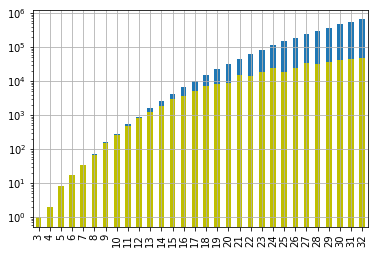

In [148]:
sl=sl.rename({'solution':'z'},axis='columns')
(df['z'].str[-1].abs().value_counts().sort_index()).plot(kind='bar')
(sl['z'].str[-1].abs().value_counts().sort_index()).plot(kind='bar',color='y')
plt.yscale('log')
plt.grid()
#plt.xlim(-0.5,8)
#plt.ylim(0,600)

In [149]:
rs=pd.DataFrame( sl['z'].str[-1].abs().value_counts().sort_index())
rs['zz']=df['z'].str[-1].abs().value_counts().sort_index()
rs

,z,zz
3,1,1
4,2,2
5,8,8
6,17,17
7,35,35
8,69,72
9,152,160
10,262,287
11,473,536
12,802,901


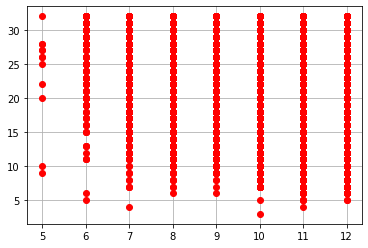

In [157]:
plt.plot(df['z'].apply(len),df['z'].str[-1].abs(),'ro')
plt.grid()

In [24]:
sl['zmax']=sl['z'].str[-1].abs()

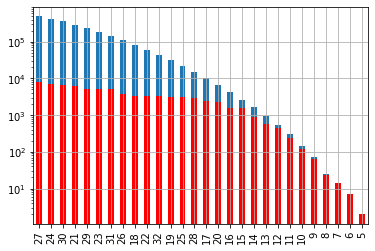

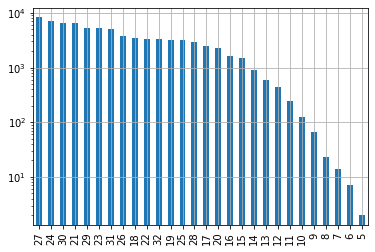

In [27]:
(sl['z'].str[-1].abs().value_counts()).plot(kind='bar')
plt.yscale('log')
plt.grid()

In [91]:
(sl['l']+sl['k']).apply(lambda l:np.abs(l).max()).max()

15

In [92]:
sl=sl.rename({'solution':'z'},axis='columns')
sl=pd.concat((sl,df[df['n']==7])).reset_index(drop=True)
sl['zs']=sl['z'].astype(str)
sl=sl.drop_duplicates('zs',keep=False).drop('zs',axis='columns').reset_index(drop=True)
sl.shape

(2, 5)

In [93]:
sl

,l,k,z,gcd,n
0,"[-1, 2, -9]","[-1, 3, 2]","[9, 9, 9, -10, -20, -26, 29]",9,7
1,"[3, -3]","[-1, -4, -8]","[7, 11, -23, -23, 27, -31, 32]",10,7


In [40]:
#sl.to_json('missing_8.json',orient='records')

In [44]:
sl

,l,k,z,gcd,n
0,"[7, -8, -5]","[-3, -6, -1, -5]","[2, 7, 7, -22, -22, -22, 25, 25]",50,8.0
1,"[4, -7, -3]","[-1, -4, 5, 3]","[9, -13, -16, -16, 19, 19, 25, -27]",28,8.0
2,"[6, -4, 4]","[-6, -3, 6, 0]","[13, -17, -17, 23, 27, 27, -28, -28]",144,8.0
3,"[-12, -3, -12]","[-12, -8, -4]","[10, -13, -19, 22, -23, 27, 27, -31]",1296,8.0
4,"[-9, 8, 5]","[-1, 3, -2, -4]","[9, -13, -19, 27, 29, 31, -32, -32]",6,8.0
5,"[-12, 4, 12]","[-12, -6, 3]","[5, 7, 7, -23, -29, -31, 32, 32]",864,8.0
6,"[14, 7, 14]","[-11, -5, -11]","[11, -14, -14, 20, 23, -29, -29, 32]",294,8.0
7,"[-3, -12, -15]","[-3, -2, 4]","[19, -22, -22, 27, 27, -28, 31, -32]",72,8.0


In [54]:
sl[sl['solution'].astype(str)=='[19, -22, -22, 27, 27, -28, 31, -32]']

,l,k,solution,gcd,n
6480,"[-3, -12, -15]","[-3, -2, 4]","[19, -22, -22, 27, 27, -28, 31, -32]",72,8


In [36]:
sl['l'].iloc[3]

[-12, -3, -12]

In [37]:
get_solution_from_list( (sl['l']+sl['k']).iloc[3] )

{'l': [-12, -3, -12],
 'k': [-12, -8, -4],
 'z': [10, -13, -19, 22, -23, 27, 27, -31],
 'gcd': 1296}

In [32]:
get_solution(sl['l'].iloc[0],sl['k'].iloc[0])

{}

In [33]:
z(sl['l'].iloc[0],sl['k'].iloc[0])

array([    0,  -100,  -350,  -350,  1100,  1100,  1100, -1250, -1250])

In [29]:
#{ tuple(x) for x in sl['z'].to_list() }.difference( { tuple(x) for x in df['z'].to_list() }  )

In [30]:
#{ tuple(x) for x in df['z'].to_list() }.difference( { tuple(x) for x in sl['solution'].to_list() }  )

In [31]:
df['z'].apply(lambda l:np.abs(l).max()).max()

32

In [37]:
[8, 9, 11, -17, -17, -17, 23]==[8, 9, 11, -17, -17, -17, 23]

True

In [ ]:
import numpy as np

In [15]:
np.unique( np.random.randint(-2,3,(200,2)),axis=0 )

array([[-2, -2],
       [-2, -1],
       [-2,  0],
       [-2,  1],
       [-2,  2],
       [-1, -2],
       [-1, -1],
       [-1,  0],
       [-1,  1],
       [-1,  2],
       [ 0, -2],
       [ 0, -1],
       [ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 1, -2],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1],
       [ 1,  2],
       [ 2, -2],
       [ 2, -1],
       [ 2,  0],
       [ 2,  1],
       [ 2,  2]])

In [5]:
import numpy as np

In [6]:
import pandas as pd

In [7]:
df=pd.read_json('/home/restrepo/Downloads/solution_6.json')
df['zs']=sl['z'].astype(str)
sl=sl.drop_duplicates('zs',keep=False).reset_index(drop=True)
sl.shape

In [25]:
df[df[6].apply(lambda l: np.abs(l).max())<=32].shape

(111, 1)

In [37]:
p=Pool()

In [4]:
import pandas as pd

In [5]:
df=pd.concat( [pd.read_json(f'solution_{n}.json') for n in  range(5,13)] )

In [6]:
df.shape

(1956284, 4)

In [7]:
df['n']=df['z'].apply(len)

df['max']=df['z'].str[-1].abs()

df=df.sort_values(['n','max','gcd']).reset_index(drop=True)

df['zs']=df['z'].astype(str)
df=df.drop_duplicates('zs').drop(['zs','n','max'],axis='columns').reset_index(drop=True)

In [8]:
df['n']=df['z'].apply(len)

In [9]:
n=8
df[df['n']<=n].drop('n',axis='columns').to_json(f'solution_{n}.json',orient='records')

In [11]:
pd.read_json('solution_8.json')

,l,k,z,gcd
0,[8],"[-2, 2]","[1, 5, -7, -8, 9]",32
1,[2],"[5, -9]","[2, 4, -7, -9, 10]",330
2,[-5],"[-4, -2]","[1, 14, -17, -18, 20]",8
3,[-4],"[2, -10]","[5, 6, -12, -21, 22]",32
4,"[0, -3, 3]","[0, -3, 5, 0]","[7, 8, -18, -22, 25]",9
...,...,...,...,...
6479,"[-6, 15, 6]","[3, 8, -9]","[9, -11, 16, -18, -19, 26, 29, -32]",1035
6480,"[8, -12, 8]","[1, -4, -14]","[1, 8, 13, 17, -22, -23, -26, 32]",1376
6481,"[15, -12, -6]","[15, -15, 10]","[14, -16, -22, 27, 27, -29, 31, -32]",2250
6482,"[-10, 5, -15]","[-10, -12, 12]","[5, 5, 5, -17, -27, -27, 28, 28]",100
